###Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

### Importing all the important libraries

In [8]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from tensorflow.keras.preprocessing.image import load_img

This assignment uses a dataset of about 2357 (2239+118) images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

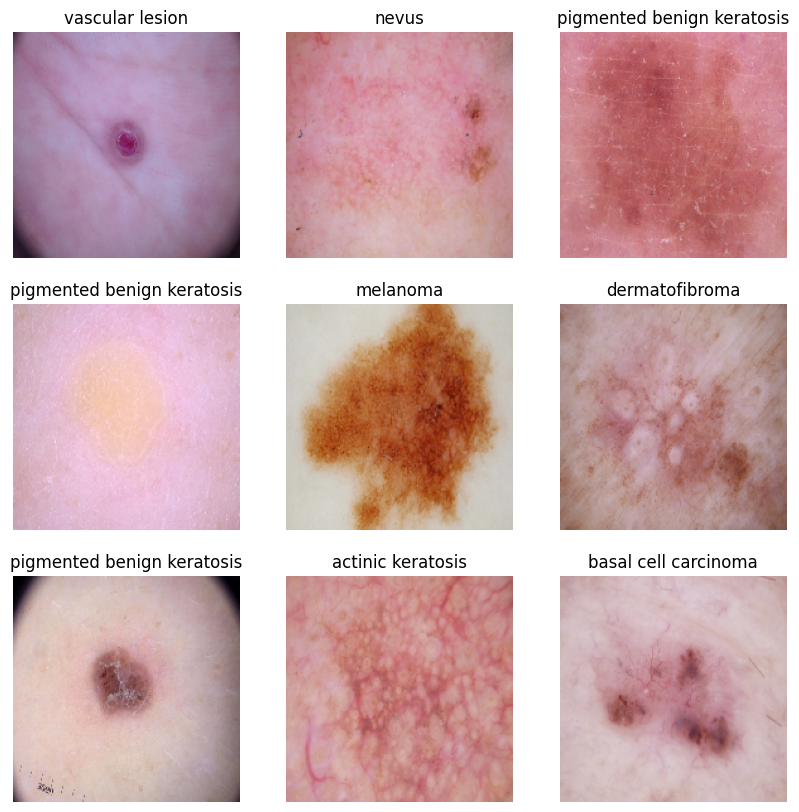

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
num_classes=9
model=Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 119ms/step - loss: 2.1348 - accuracy: 0.2165 - val_loss: 2.0410 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8896 - accuracy: 0.3025 - val_loss: 1.6873 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6265 - accuracy: 0.4336 - val_loss: 1.5483 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5191 - accuracy: 0.4688 - val_loss: 1.4322 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4634 - accuracy: 0.4860 - val_loss: 1.5985 - val_accuracy: 0.4452
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3068 - accuracy: 0.5391 - val_loss: 1.3840 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2268 - accuracy: 0.5647 - val_loss: 1.3940 - val_accuracy: 0.5190
Epoch 8/20


### Visualizing training results

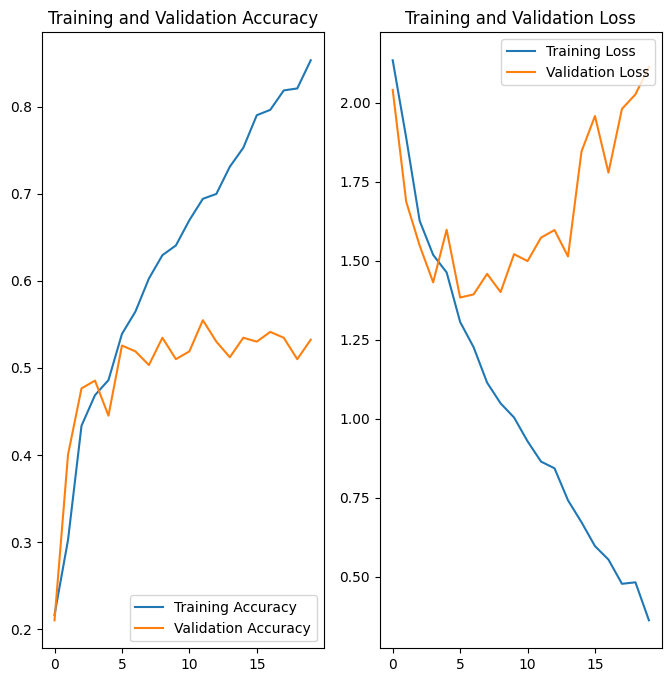

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
- Training data accuracy is more than 80% whereas validation accuracy is still at ~55%. There is huge difference between Training and Validation accuracy which is clear case of Overfitting.

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_aug=keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

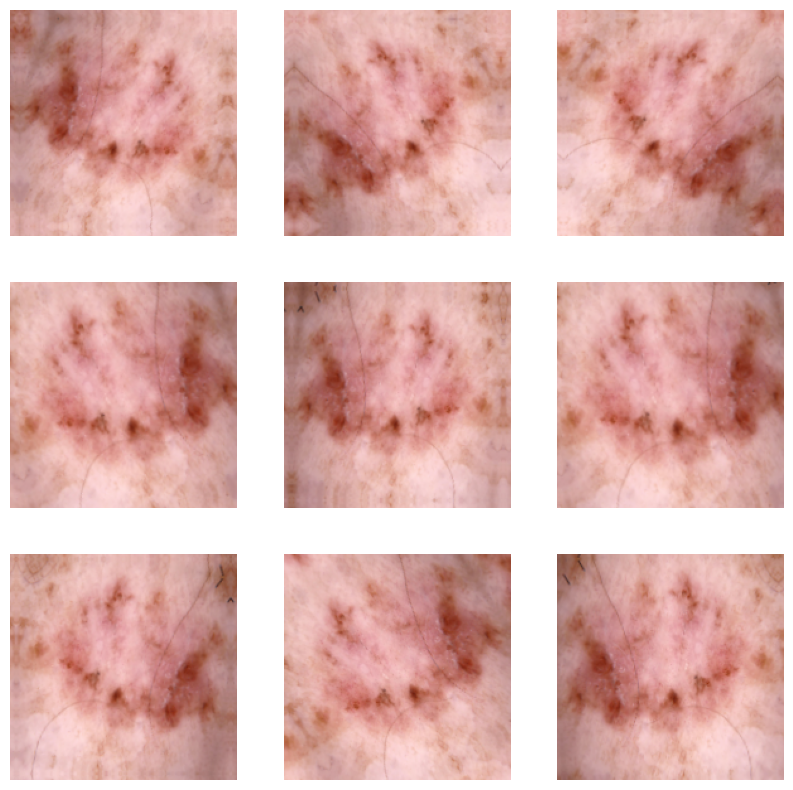

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    image_aug=data_aug(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image_aug[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model=Sequential([
    data_aug,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])



### Compiling the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 36ms/step - loss: 2.0453 - accuracy: 0.2243 - val_loss: 2.0195 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 1.8347 - accuracy: 0.3153 - val_loss: 1.6979 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 2s 35ms/step - loss: 1.6349 - accuracy: 0.4046 - val_loss: 1.5502 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5670 - accuracy: 0.4470 - val_loss: 1.4683 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4911 - accuracy: 0.4715 - val_loss: 1.4354 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4278 - accuracy: 0.5045 - val_loss: 1.3847 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3431 - accuracy: 0.5340 - val_loss: 1.4450 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

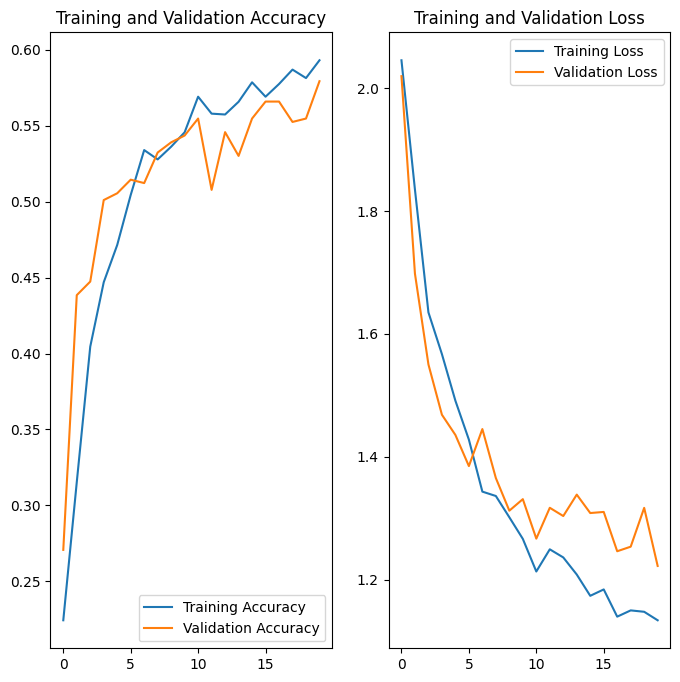

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Comment**
- Problem of underfitting is solved now, after using augmented data.
- Acurracy for both training and validation data is now with in same range.
- But acurracy of both training and validation data is very low, so model is very simple and underfitting now.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
lst = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
print(len(lst))

2239


In [29]:
df_dict_original = dict(zip(path_list,lst))
print(list(df_dict_original.items())[:2])

[('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0031955.jpg', 'vascular lesion'), ('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0030956.jpg', 'vascular lesion')]


In [30]:
orig_df = pd.DataFrame(list(df_dict_original.items()),columns=['Path','Label'])
orig_df.head()

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,vascular lesion
1,/content/Skin cancer ISIC The International Sk...,vascular lesion
2,/content/Skin cancer ISIC The International Sk...,vascular lesion
3,/content/Skin cancer ISIC The International Sk...,vascular lesion
4,/content/Skin cancer ISIC The International Sk...,vascular lesion


In [31]:
orig_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
**Answer** : seborrheic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
**Answer** : pigmented benign keratosis and melanoma classes dominate the samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6F2B3FFD0>: 100%|██████████| 500/500 [00:22<00:00, 22.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6EB7BE3E0>: 100%|██████████| 500/500 [00:24<00:00, 20.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA6F2F964A0>: 100%|██████████| 500/500 [00:22<00:00, 21.79 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FA6F2BF9000>: 100%|██████████| 500/500 [02:04<00:00,  4.02 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FA6EBB0EFB0>: 100%|██████████| 500/500 [01:56<00:00,  4.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA6F2C1DE10>: 100%|██████████| 500/500 [00:26<00:00, 18.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA6EAF50790>: 100%|██████████| 500/500 [00:54<00:00,  9.14 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7A40F8FA0>: 100%|██████████| 500/500 [00:29<00:00, 17.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6F2C1CA90>: 100%|██████████| 500/500 [00:28<00:00, 17.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028163.jpg_eb5cf0eb-a800-4080-b656-d9d6988df60d.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_2785bca0-5350-4639-b82f-cd8d95be4b96.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026393.jpg_5b394606-2d97-4689-80cf-d06a5cd259db.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027563.jpg_e0f35958-de56-4ea8-9883-6a903b7460cf.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028885.jpg_28bf7e70-26fe-41e2-bad5-bbb848ebdf4d.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collab

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = orig_df.append(df2)

<ipython-input-38-6b1e44616a13>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = orig_df.append(df2)


In [39]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
model=Sequential([
    data_aug,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 38s 206ms/step - loss: 1.9130 - accuracy: 0.2697 - val_loss: 1.6111 - val_accuracy: 0.4128
Epoch 2/30
169/169 [==============================] - 34s 195ms/step - loss: 1.5052 - accuracy: 0.4219 - val_loss: 1.4597 - val_accuracy: 0.4469
Epoch 3/30
169/169 [==============================] - 38s 212ms/step - loss: 1.3883 - accuracy: 0.4651 - val_loss: 1.3546 - val_accuracy: 0.4766
Epoch 4/30
169/169 [==============================] - 39s 227ms/step - loss: 1.3356 - accuracy: 0.4957 - val_loss: 1.3174 - val_accuracy: 0.5174
Epoch 5/30
169/169 [==============================] - 34s 195ms/step - loss: 1.2748 - accuracy: 0.5104 - val_loss: 1.1926 - val_accuracy: 0.5405
Epoch 6/30
169/169 [==============================] - 39s 225ms/step - loss: 1.2366 - accuracy: 0.5237 - val_loss: 1.2088 - val_accuracy: 0.5390
Epoch 7/30
169/169 [==============================] - 34s 196ms/step - loss: 1.2258 - accuracy: 0.5315 - val_loss: 1.2110 - val_ac

#### **Todo:**  Visualize the model results

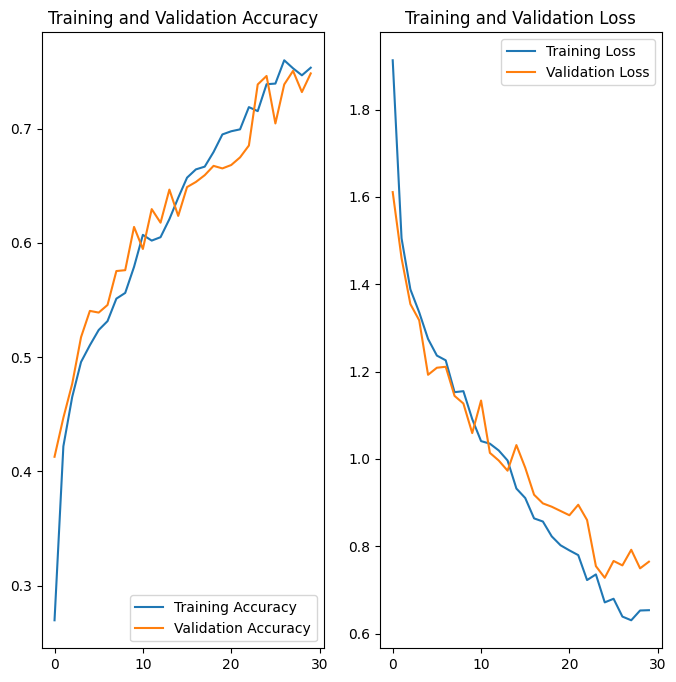

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Comment**
- In Final model , training accuracy is ~ 80% and validation accuracy is also little less than 80%, so there is no issue with model underfitting now and CNN model is good to use.
- Yes , Class rebalanced improved the performance of the model.
